In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_features.correction_features import create_correction_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes.columns


Index(['id_devis', 'num_devis', 'nom_devis', 'nom_agence', 'nom_filiale_zone',
       'nom_region', 'statut_devis', 'fg_devis_emis', 'fg_devis_refuse',
       'fg_devis_accepte', 'dt_creation_devis', 'dt_signature_devis',
       'fg_3_mois_mature', 'type_devis', 'mt_apres_remise_ht_devis',
       'mt_marge', 'nb_devis_emis', 'mt_apres_remise_ht_emis_devis',
       'mt_marge_emis_devis', 'mt_remise_exceptionnelle_ht',
       'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis', 'mt_prime_cee',
       'mt_prime_maprimerenov', 'fg_activite_commerciale',
       'prenom_nom_createur', 'prenom_nom_commercial', 'nom_campagne',
       'famille_equipement_produit', 'type_equipement_produit',
       'dth_emission_devis', 'dt_emission_calcule_devis', 'id_opportunite',
       'fg_devis_principal', 'lb_statut_preparation_chantier', 'numero_compte',
       'dt_visite_commerciale', 'fonction_commercial',
       'regroup_famille_equipement_produit', 'marque_produit',
       'modele_produit', 'dt_factu


📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 10.7 seconds
⚠️  10.7s (target was 3s)
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 23,888
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/23,888 customers
  Processed 5,000/23,888 customers
  Processed 10,000/23,888 customers
  Processed 15,000/23,888 customers
  Processed 20,000/23,888 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 23,888
   First converters: 9,458 (39.6%)
   Never converters: 14,430

📊 Distribution check:
   Converters with 0 historical quotes: 7,105
   Non-conver

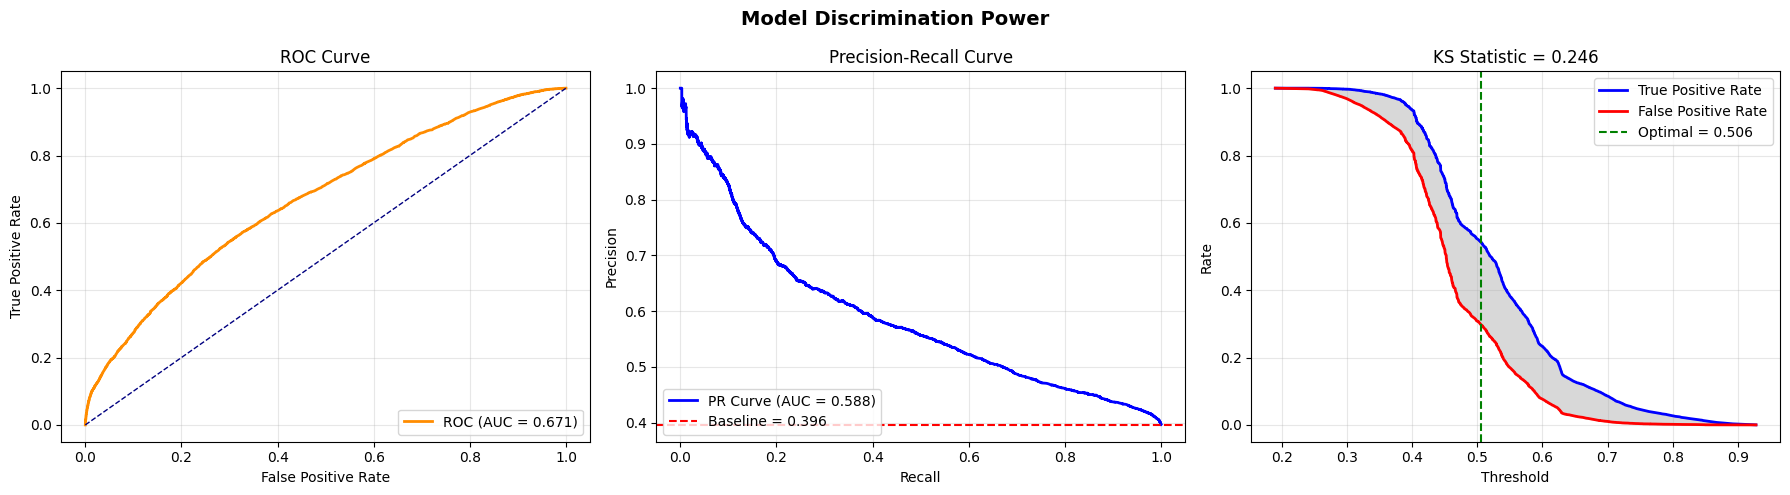

• ROC-AUC: 0.6705
• PR-AUC: 0.5875
• KS Statistic: 0.246 (WEAK discrimination)
• Optimal Threshold: 0.506

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.699
Decile 10 mean prob: 0.334


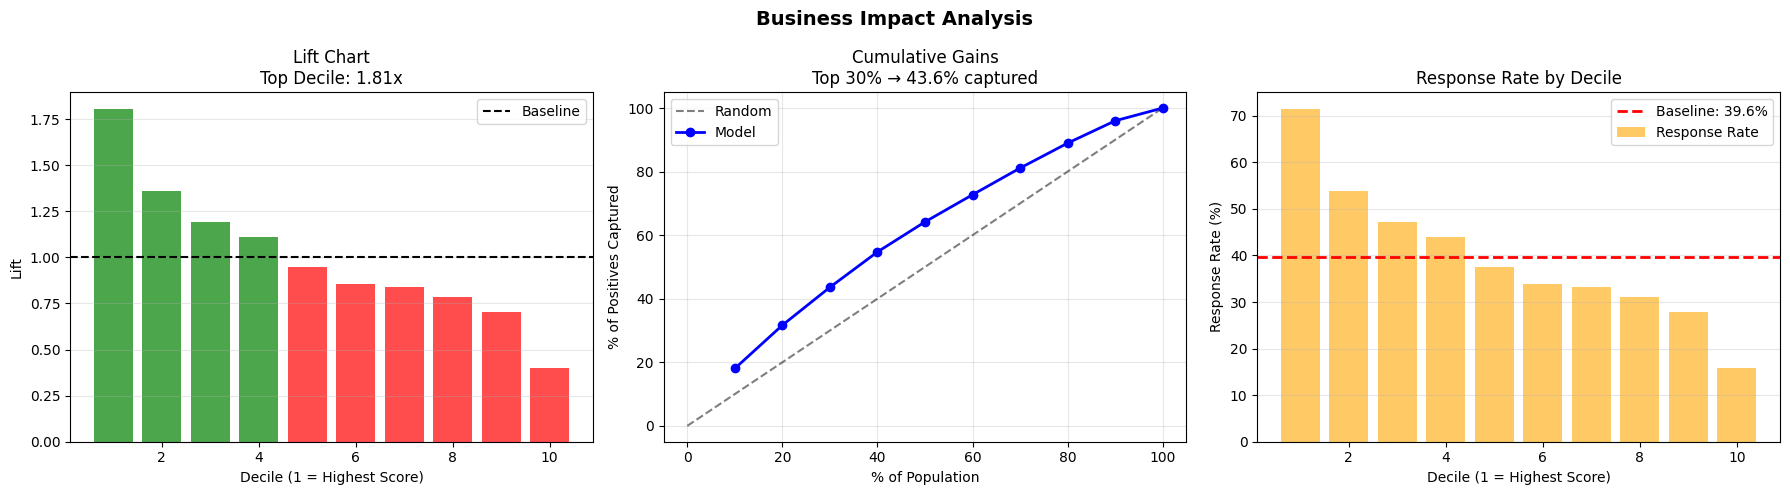

• Top Decile Lift: 0.40x
• Top 30% captures: 43.6% of positives
• Baseline response rate: 39.6%
• Top decile response: 71.5%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


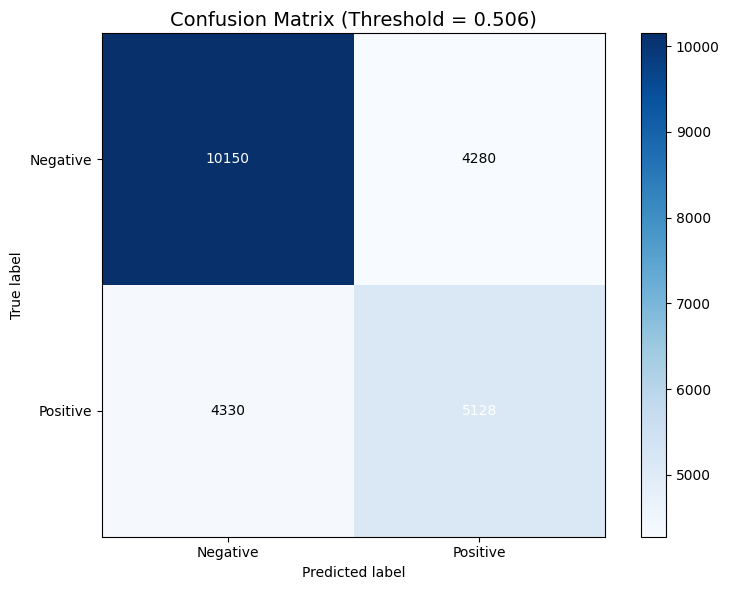

At threshold 0.506:
• Accuracy: 0.640
• Precision: 0.545
• Recall: 0.542
• F1-Score: 0.544
• True Positives: 5128
• False Positives: 4280
• True Negatives: 10150
• False Negatives: 4330

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.246 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.40x better than random
   Coverage: Top 30% → 43.6% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6705 (Excellent if >0.8)
   PR-AUC: 0.5875 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.506
   Precision at threshold: 0.545
   Recall at threshold: 0.542

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.659
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


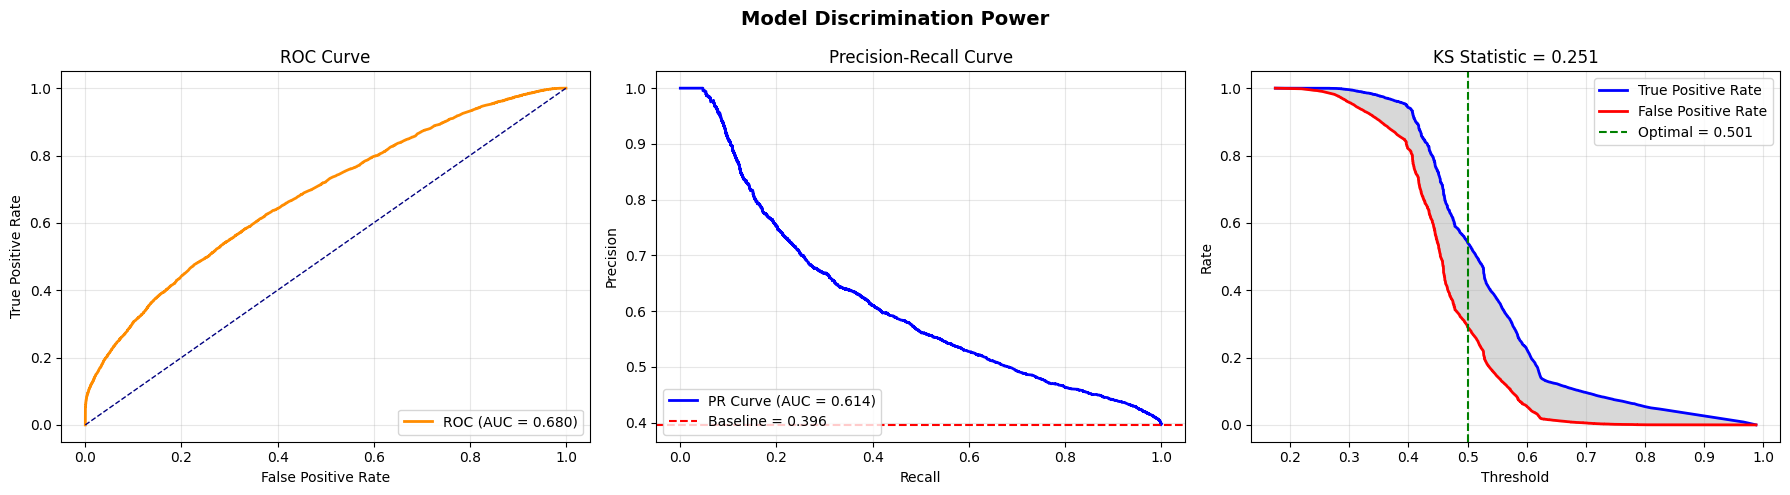

• ROC-AUC: 0.6801
• PR-AUC: 0.6142
• KS Statistic: 0.251 (WEAK discrimination)
• Optimal Threshold: 0.501

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.717
Decile 10 mean prob: 0.324


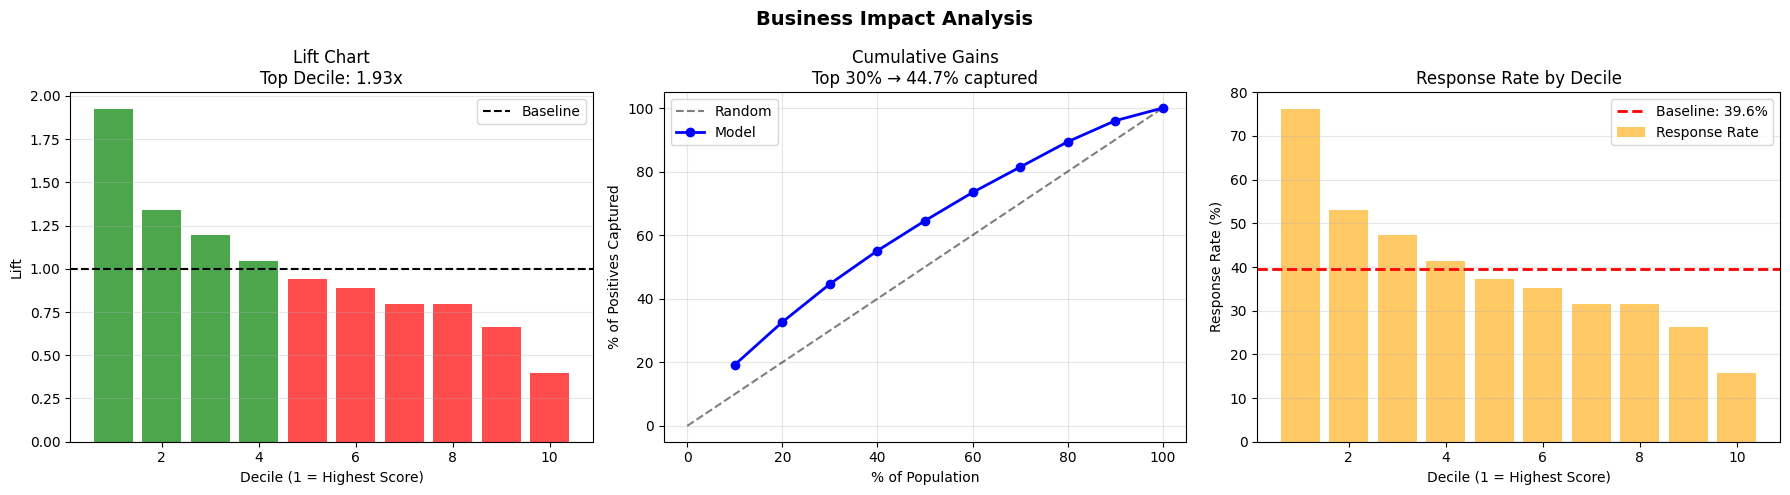

• Top Decile Lift: 0.40x
• Top 30% captures: 44.7% of positives
• Baseline response rate: 39.6%
• Top decile response: 76.2%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


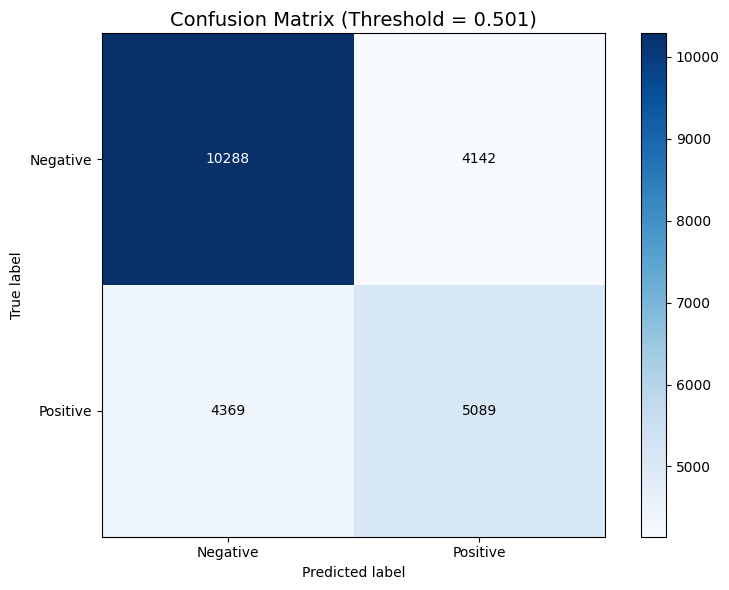

At threshold 0.501:
• Accuracy: 0.644
• Precision: 0.551
• Recall: 0.538
• F1-Score: 0.545
• True Positives: 5089
• False Positives: 4142
• True Negatives: 10288
• False Negatives: 4369

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.251 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.40x better than random
   Coverage: Top 30% → 44.7% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6801 (Excellent if >0.8)
   PR-AUC: 0.6142 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.501
   Precision at threshold: 0.551
   Recall at threshold: 0.538

🧪 TEST 3: NEW FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.693
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


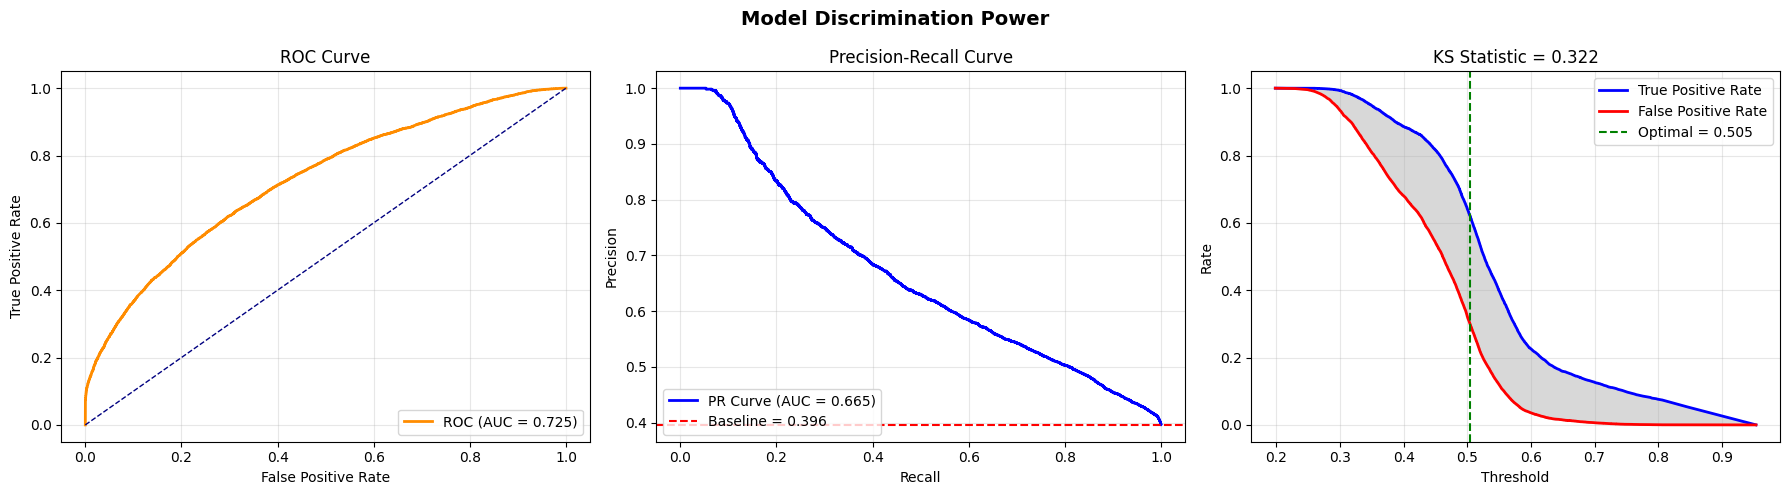

• ROC-AUC: 0.7252
• PR-AUC: 0.6654
• KS Statistic: 0.322 (MODERATE discrimination)
• Optimal Threshold: 0.505

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.738
Decile 10 mean prob: 0.301


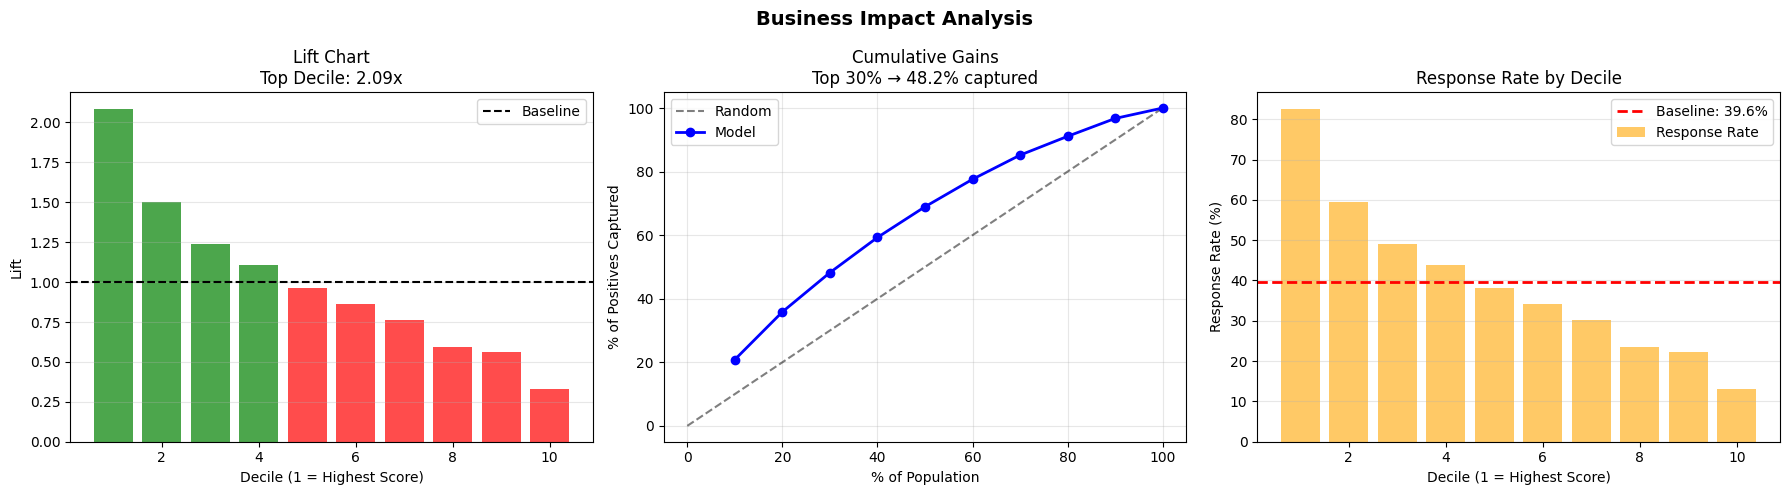

• Top Decile Lift: 0.33x
• Top 30% captures: 48.2% of positives
• Baseline response rate: 39.6%
• Top decile response: 82.6%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


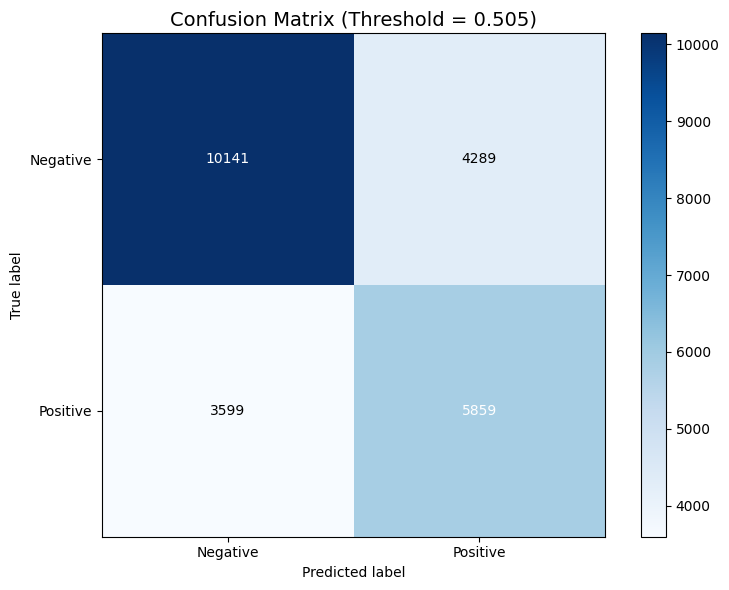

At threshold 0.505:
• Accuracy: 0.670
• Precision: 0.577
• Recall: 0.619
• F1-Score: 0.598
• True Positives: 5859
• False Positives: 4289
• True Negatives: 10141
• False Negatives: 3599

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.322 (MODERATE discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.33x better than random
   Coverage: Top 30% → 48.2% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7252 (Excellent if >0.8)
   PR-AUC: 0.6654 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.505
   Precision at threshold: 0.577
   Recall at threshold: 0.619


{'y_true': array([0., 0., 1., ..., 0., 0., 0.], shape=(23888,)),
 'y_pred_proba': array([0.41092115, 0.43749896, 0.38403098, ..., 0.49144945, 0.2446731 ,
        0.45809749], shape=(23888,)),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(23888,)),
 'roc_auc': 0.7251776427923605,
 'pr_auc': 0.6654261114254244,
 'ks_statistic': np.float64(0.3222475790037643),
 'optimal_threshold': np.float64(0.5048231751829232),
 'top_decile_lift': np.float64(0.32773741564676545),
 'decile_stats':    decile  count  positives  mean_prob  response_rate      lift  \
 0       1   2389     1973.0   0.737571       0.825869  2.085890   
 1       2   2389     1419.0   0.579579       0.593972  1.500192   
 2       3   2389     1169.0   0.544206       0.489326  1.235887   
 3       4   2388     1046.0   0.519138       0.438023  1.106313   
 4       5   2389      913.0   0.499789       0.382168  0.965240   
 5       6   2389      818.0   0.478056       0.342403  0.864804   
 6       7   2388      719.0   0.44956

In [2]:
print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE FEATURES")
print("="*80)


# Create feature list
feature_funcs = [create_customer_features, create_sequence_features, create_brand_features, 
                 create_model_features, create_market_features,
                 create_equipment_features, create_solution_complexity_features,
                 create_timeline_features, create_advanced_timeline_features,
                 create_commercial_role_features, create_process_features
                 , create_correction_features
                ]


new_df = feature_funcs[0](df_quotes)
customer_df = new_df
for func in feature_funcs[1:]:
    new_df_ = func(df_quotes)

    new_df = pd.merge(new_df, new_df_, on='numero_compte', how='left', suffixes=('_dup', ''))
    new_df = new_df.drop(columns=[x for x in new_df.columns if '_dup' in x], errors='ignore')
    print(len(new_df))
    if func == create_sequence_features: sequence_df = new_df


# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")

new_df = create_timeline_interaction_features(new_df)
X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")


print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result = train_rf(X_customer_clean, y_customer_clean, 'improved_customer_model')
df = X_customer_clean.copy()
df['converted'] = y_customer_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_prediction_model')
df = X_sequence_clean.copy()
df['converted'] = y_sequence_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')


# Test 3: New features 
print("\n🧪 TEST 3: NEW FEATURES (Advanced)")
result = train_rf(X_new_clean, y_new_clean, 'sequence_prediction_model')
__result = result
df = X_new_clean.copy()
df['converted'] = y_new_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

In [3]:
import time


def benchmark_function(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# Test both versions
original_time = benchmark_function(create_process_features, df_quotes)[1] # 56.6
print(original_time)

🚀 ULTRA-FAST CUSTOMER-LEVEL PROCESS FEATURES
Processing 34,014 quotes for 23,888 customers
👥 Vectorized aggregation...
⚡ Vectorized feature calculation...
  → Creating derived features...
📝 Finalizing features...

✅ Created 11 process features for 23,888 customers
⏱️  Execution time: 5.03 seconds

📊 FEATURE SUMMARY:
--------------------------------------------------
Adoption Rate             : mean = 0.567, std = 0.489
Ever Used (%)             : 57.9%
Consistency               : mean = 0.974, std = 0.158
Confidence Score          : mean = 0.811, std = 0.219
5.034274578094482


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def enhanced_data_discovery_analysis(df_quotes, X_new_clean=None):
    """
    Comprehensive data discovery focusing on new segments and predictive signals
    Uses df_quotes for raw analysis, X_new_clean for feature analysis
    """
    print("=" * 80)
    print("ENHANCED DATA DISCOVERY ANALYSIS - UPGRADED DATASET")
    print("=" * 80)
    
    # Initialize results dictionary
    analysis_results = {}
    
    # ========== DATA STRUCTURE CHECK ==========
    print("\n📁 DATASET STRUCTURE ANALYSIS")
    print("-" * 60)
    print(f"• df_quotes shape: {df_quotes.shape}")
    print(f"• df_quotes columns: {len(df_quotes.columns)}")
    
    if X_new_clean is not None:
        print(f"• X_new_clean shape: {X_new_clean.shape}")
        print(f"• X_new_clean columns: {len(X_new_clean.columns)}")
    
    # Check for customer ID column
    customer_id_col = 'numero_compte'
    if customer_id_col not in df_quotes.columns:
        # Try to find alternative customer ID column
        possible_ids = ['customer_id', 'client_id', 'id_client', 'customer_number']
        for col in possible_ids:
            if col in df_quotes.columns:
                customer_id_col = col
                break
        
        if customer_id_col == 'numero_compte':
            print("❌ ERROR: No customer ID column found in df_quotes!")
            print("Available columns:", list(df_quotes.columns))
            return analysis_results
    
    print(f"✅ Using customer ID column: '{customer_id_col}'")
    print(f"✅ Unique customers in df_quotes: {df_quotes[customer_id_col].nunique():,}")
    
    # ========== 1. CUSTOMER SEGMENT ANALYSIS ==========
    print("\n\n📊 1. CUSTOMER SEGMENT ANALYSIS")
    print("-" * 60)
    
    # Check for client status column
    client_status_col = None
    possible_cols = ['client_status', 'statut_client', 'fg_statut_client', 'status_client']
    
    for col in possible_cols:
        if col in df_quotes.columns:
            client_status_col = col
            break
    
    if client_status_col:
        print(f"✅ Found client status column: '{client_status_col}'")
        
        # Segment distribution
        segment_counts = df_quotes[client_status_col].value_counts()
        segment_pct = df_quotes[client_status_col].value_counts(normalize=True) * 100
        
        print(f"\n📈 Client Segment Distribution:")
        for segment, count in segment_counts.items():
            pct = segment_pct[segment]
            print(f"   • {segment}: {count:,} quotes ({pct:.1f}%)")
        
        # Analyze conversion rates by segment
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Conversion Rates by Segment:")
            conversion_by_segment = df_quotes.groupby(client_status_col)['fg_devis_accepte'].mean() * 100
            
            for segment, conv_rate in conversion_by_segment.items():
                print(f"   • {segment}: {conv_rate:.1f}% conversion rate")
            
            analysis_results['segment_conversion_rates'] = conversion_by_segment
        
        # Analyze quote patterns by segment
        print(f"\n📝 Quote Patterns by Segment:")
        quotes_by_segment = df_quotes.groupby(client_status_col)[customer_id_col].agg(['count', 'nunique'])
        quotes_by_segment['avg_quotes_per_customer'] = quotes_by_segment['count'] / quotes_by_segment['nunique']
        
        print(f"   Quote statistics by segment:")
        for segment in quotes_by_segment.index:
            total_quotes = quotes_by_segment.loc[segment, 'count']
            unique_customers = quotes_by_segment.loc[segment, 'nunique']
            avg_quotes = quotes_by_segment.loc[segment, 'avg_quotes_per_customer']
            print(f"   • {segment}: {total_quotes:,} quotes, {unique_customers:,} customers ({avg_quotes:.2f} quotes/customer)")
    else:
        print("❌ No client status column found in df_quotes")
    
    # ========== 2. ENGAGEMENT SIGNAL ANALYSIS ==========
    print("\n\n📈 2. ENGAGEMENT SIGNAL ANALYSIS")
    print("-" * 60)
    
    # Check date column for temporal analysis
    date_col = 'dt_creation_devis'
    if date_col in df_quotes.columns:
        df_quotes[date_col] = pd.to_datetime(df_quotes[date_col], errors='coerce')
        
        # Engagement frequency analysis
        engagement_stats = df_quotes.groupby(customer_id_col).agg(
            total_quotes=(customer_id_col, 'size'),
            engagement_days=(date_col, lambda x: (x.max() - x.min()).days if len(x) > 1 else 0)
        ).reset_index()
        
        # Calculate quotes per day for customers with multiple quotes
        engagement_stats['quotes_per_day'] = engagement_stats.apply(
            lambda x: x['total_quotes'] / max(x['engagement_days'], 1), axis=1
        )
        
        print("📊 Customer Engagement Patterns:")
        print(f"   • Average quotes per customer: {engagement_stats['total_quotes'].mean():.2f}")
        print(f"   • Median quotes per customer: {engagement_stats['total_quotes'].median():.1f}")
        print(f"   • Max quotes for a single customer: {engagement_stats['total_quotes'].max()}")
        print(f"   • Average engagement days: {engagement_stats[engagement_stats['engagement_days'] > 0]['engagement_days'].mean():.1f}")
        
        # Single vs multi-quote analysis
        single_quote_customers = (engagement_stats['total_quotes'] == 1).sum()
        multi_quote_customers = (engagement_stats['total_quotes'] > 1).sum()
        total_customers = len(engagement_stats)
        
        print(f"\n🔢 Single vs Multi-Quote Customers:")
        print(f"   • Single-quote customers: {single_quote_customers:,} ({single_quote_customers/total_customers*100:.1f}%)")
        print(f"   • Multi-quote customers: {multi_quote_customers:,} ({multi_quote_customers/total_customers*100:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Get customer-level conversion
            customer_conversion = df_quotes.groupby(customer_id_col)['fg_devis_accepte'].max().reset_index()
            engagement_stats = engagement_stats.merge(customer_conversion, on=customer_id_col)
            
            # Conversion rates by engagement pattern
            conversion_single = engagement_stats[engagement_stats['total_quotes'] == 1]['fg_devis_accepte'].mean() * 100
            conversion_multi = engagement_stats[engagement_stats['total_quotes'] > 1]['fg_devis_accepte'].mean() * 100
            
            print(f"\n🎯 Conversion by Engagement Pattern:")
            print(f"   • Single-quote customers: {conversion_single:.1f}% conversion")
            print(f"   • Multi-quote customers: {conversion_multi:.1f}% conversion")
            
            if conversion_single > conversion_multi:
                print(f"   ⚡ INSIGHT: Single-quote customers convert {conversion_single - conversion_multi:.1f}% HIGHER!")
            else:
                print(f"   ⚡ INSIGHT: Multi-quote customers convert {conversion_multi - conversion_single:.1f}% HIGHER!")
            
            analysis_results['single_vs_multi_conversion'] = {
                'single': conversion_single,
                'multi': conversion_multi,
                'difference': abs(conversion_single - conversion_multi)
            }
    else:
        print("❌ No date column found for engagement analysis")
    
    # ========== 3. PRICE SIGNAL ANALYSIS ==========
    print("\n\n💰 3. PRICE SIGNAL ANALYSIS")
    print("-" * 60)
    
    price_cols = ['total_price', 'montant_total', 'prix_total', 'montant_devis', 'montant_ttc']
    price_col = None
    
    for col in price_cols:
        if col in df_quotes.columns and df_quotes[col].notna().sum() > 0:
            price_col = col
            break
    
    if price_col:
        # Clean price data
        df_quotes[price_col] = pd.to_numeric(df_quotes[price_col], errors='coerce')
        
        print(f"✅ Found price column: '{price_col}'")
        print(f"\n📊 Price Statistics (all quotes):")
        print(f"   • Mean price: €{df_quotes[price_col].mean():,.0f}")
        print(f"   • Median price: €{df_quotes[price_col].median():,.0f}")
        print(f"   • Min price: €{df_quotes[price_col].min():,.0f}")
        print(f"   • Max price: €{df_quotes[price_col].max():,.0f}")
        print(f"   • Price std: €{df_quotes[price_col].std():,.0f}")
        print(f"   • Missing values: {df_quotes[price_col].isna().sum():,} ({df_quotes[price_col].isna().mean()*100:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Price analysis by conversion
            print(f"\n🎯 Price Analysis by Conversion Status:")
            
            converted_prices = df_quotes[df_quotes['fg_devis_accepte'] == 1][price_col]
            non_converted_prices = df_quotes[df_quotes['fg_devis_accepte'] == 0][price_col]
            
            print(f"   • Converted quotes: €{converted_prices.mean():,.0f} (median: €{converted_prices.median():,.0f})")
            print(f"   • Non-converted quotes: €{non_converted_prices.mean():,.0f} (median: €{non_converted_prices.median():,.0f})")
            
            # Price quartile analysis
            valid_prices = df_quotes[price_col].dropna()
            if len(valid_prices) > 0:
                df_quotes['price_quartile'] = pd.qcut(df_quotes[price_col], q=4, 
                                                     labels=['Q1 (lowest)', 'Q2', 'Q3', 'Q4 (highest)'], 
                                                     duplicates='drop')
                quartile_conversion = df_quotes.groupby('price_quartile')['fg_devis_accepte'].mean() * 100
                
                print(f"\n📈 Conversion by Price Quartile:")
                for quartile, rate in quartile_conversion.items():
                    print(f"   • {quartile}: {rate:.1f}% conversion")
                
                # Find optimal price range
                best_quartile = quartile_conversion.idxmax()
                best_rate = quartile_conversion.max()
                print(f"   ⚡ OPTIMAL: {best_quartile} has highest conversion at {best_rate:.1f}%")
                
                analysis_results['price_quartile_conversion'] = quartile_conversion
    else:
        print("❌ No price column found for price analysis")
    
    # ========== 4. BRAND SIGNAL ANALYSIS ==========
    print("\n\n🏷️ 4. BRAND SIGNAL ANALYSIS")
    print("-" * 60)
    
    brand_cols = ['brand', 'marque', 'nom_marque', 'marque_produit', 'libelle_marque']
    brand_col = None
    
    for col in brand_cols:
        if col in df_quotes.columns and df_quotes[col].notna().sum() > 0:
            brand_col = col
            break
    
    if brand_col:
        print(f"✅ Found brand column: '{brand_col}'")
        
        # Clean brand names
        df_quotes[brand_col] = df_quotes[brand_col].astype(str).str.strip().str.upper()
        
        # Brand distribution
        brand_counts = df_quotes[brand_col].value_counts()
        brand_pct = df_quotes[brand_col].value_counts(normalize=True) * 100
        
        print(f"\n🏆 Top 10 Brands by Quote Volume:")
        top_brands = brand_counts.head(10)
        
        for i, (brand, count) in enumerate(top_brands.items(), 1):
            pct = brand_pct[brand]
            print(f"   {i:2d}. {brand:25} {count:6,} quotes ({pct:.1f}% share)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Brand conversion analysis
            print(f"\n🎯 Top 10 Brands by Conversion Rate (min 50 quotes):")
            
            # Filter brands with sufficient data
            brand_stats = df_quotes.groupby(brand_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            # Get top converting brands with enough quotes
            qualifying_brands = brand_stats[brand_stats['quote_count'] >= 50]
            
            if len(qualifying_brands) > 0:
                top_converting = qualifying_brands.nlargest(10, 'conversion_rate')
                
                for i, (brand, stats) in enumerate(top_converting.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {brand:25} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                # Low converting brands
                print(f"\n⚠️  Bottom 5 Converting Brands (min 50 quotes):")
                low_converting = qualifying_brands.nsmallest(5, 'conversion_rate')
                
                for i, (brand, stats) in enumerate(low_converting.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {brand:25} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                analysis_results['brand_conversion_stats'] = qualifying_brands
            else:
                print("   No brands have sufficient data for conversion analysis")
    else:
        print("❌ No brand column found for brand analysis")
    
    # ========== 5. EQUIPMENT SIGNAL ANALYSIS ==========
    print("\n\n⚙️ 5. EQUIPMENT SIGNAL ANALYSIS")
    print("-" * 60)
    
    equipment_cols = ['regroup_famille_equipement_produit', 'famille_equipement_produit', 
                      'equipment_type', 'type_equipement', 'libelle_equipement']
    equipment_col = None
    
    for col in equipment_cols:
        if col in df_quotes.columns and df_quotes[col].notna().sum() > 0:
            equipment_col = col
            break
    
    if equipment_col:
        print(f"✅ Found equipment column: '{equipment_col}'")
        
        # Clean equipment names
        df_quotes[equipment_col] = df_quotes[equipment_col].astype(str).str.strip()
        
        # Equipment distribution
        equipment_counts = df_quotes[equipment_col].value_counts()
        equipment_pct = df_quotes[equipment_col].value_counts(normalize=True) * 100
        
        print(f"\n🔧 Top 10 Equipment Categories:")
        for i, (category, count) in enumerate(equipment_counts.head(10).items(), 1):
            pct = equipment_pct[category]
            print(f"   {i:2d}. {category:35} {count:6,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            # Equipment conversion analysis
            print(f"\n🎯 Equipment Conversion Analysis (min 50 quotes):")
            
            equipment_stats = df_quotes.groupby(equipment_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            # Get top converting equipment categories
            qualifying_equipment = equipment_stats[equipment_stats['quote_count'] >= 50]
            
            if len(qualifying_equipment) > 0:
                top_equipment = qualifying_equipment.nlargest(8, 'conversion_rate')
                
                for i, (category, stats) in enumerate(top_equipment.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {category:35} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                analysis_results['equipment_conversion_stats'] = equipment_stats
            else:
                print("   No equipment categories have sufficient data for conversion analysis")
    else:
        print("❌ No equipment column found for equipment analysis")
    
    # ========== 6. PROCESS ADOPTION ANALYSIS ==========
    print("\n\n🔄 6. PROCESS ADOPTION ANALYSIS")
    print("-" * 60)
    
    process_cols = ['fg_nouveau_process_relance_devis', 'nouveau_process', 'process_type']
    process_col = None
    
    for col in process_cols:
        if col in df_quotes.columns:
            process_col = col
            break
    
    if process_col:
        print(f"✅ Found process column: '{process_col}'")
        
        process_dist = df_quotes[process_col].value_counts(normalize=True) * 100
        
        print(f"\n📊 Process Distribution:")
        total_quotes = len(df_quotes)
        for process, count in df_quotes[process_col].value_counts().items():
            pct = count / total_quotes * 100
            if pd.isna(process):
                print(f"   • Missing/Unknown: {count:,} quotes ({pct:.1f}%)")
            else:
                process_name = "New Process" if process == 1 else "Old Process"
                print(f"   • {process_name}: {count:,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Process Conversion Analysis:")
            process_conversion = df_quotes.groupby(process_col)['fg_devis_accepte'].mean() * 100
            
            for process, conv_rate in process_conversion.items():
                if pd.isna(process):
                    process_name = "Missing/Unknown"
                else:
                    process_name = "New Process" if process == 1 else "Old Process"
                print(f"   • {process_name}: {conv_rate:.1f}% conversion")
            
            # Calculate improvement
            if 1 in process_conversion.index and 0 in process_conversion.index:
                new_rate = process_conversion[1]
                old_rate = process_conversion[0]
                improvement = new_rate - old_rate
                print(f"   ⚡ IMPACT: New process shows {improvement:+.1f}% conversion change")
            
            analysis_results['process_conversion'] = process_conversion
    else:
        print("❌ No process column found for process analysis")
    
    # ========== 7. COMMERCIAL ROLE ANALYSIS ==========
    print("\n\n👥 7. COMMERCIAL ROLE ANALYSIS")
    print("-" * 60)
    
    role_cols = ['fonction_commercial', 'commercial_role', 'role_commercial']
    role_col = None
    
    for col in role_cols:
        if col in df_quotes.columns:
            role_col = col
            break
    
    if role_col:
        print(f"✅ Found commercial role column: '{role_col}'")
        
        role_counts = df_quotes[role_col].value_counts()
        
        print(f"\n📊 Top 10 Commercial Roles:")
        for i, (role, count) in enumerate(role_counts.head(10).items(), 1):
            pct = count / len(df_quotes) * 100
            print(f"   {i:2d}. {role:30} {count:6,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Top Converting Roles (min 30 quotes):")
            
            role_stats = df_quotes.groupby(role_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            # Filter for significant roles
            significant_roles = role_stats[role_stats['quote_count'] >= 30]
            
            if len(significant_roles) > 0:
                top_roles = significant_roles.nlargest(10, 'conversion_rate')
                
                for i, (role, stats) in enumerate(top_roles.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    print(f"   {i:2d}. {role:30} {conv_rate:5.1f}% conversion ({count:,} quotes)")
                
                analysis_results['role_conversion_stats'] = significant_roles
            else:
                print("   No roles have sufficient data for conversion analysis")
    else:
        print("❌ No commercial role column found")
    
    # ========== 8. AGENCY PERFORMANCE ANALYSIS ==========
    print("\n\n🏢 8. AGENCY PERFORMANCE ANALYSIS")
    print("-" * 60)
    
    agency_cols = ['code_agence', 'agence', 'nom_agence', 'libelle_agence']
    agency_col = None
    
    for col in agency_cols:
        if col in df_quotes.columns:
            agency_col = col
            break
    
    if agency_col:
        print(f"✅ Found agency column: '{agency_col}'")
        
        agency_counts = df_quotes[agency_col].value_counts()
        
        print(f"\n📊 Top 10 Agencies by Quote Volume:")
        for i, (agency, count) in enumerate(agency_counts.head(10).items(), 1):
            pct = count / len(df_quotes) * 100
            print(f"   {i:2d}. {agency:25} {count:6,} quotes ({pct:.1f}%)")
        
        if 'fg_devis_accepte' in df_quotes.columns:
            print(f"\n🎯 Agency Conversion Performance (min 100 quotes):")
            
            agency_stats = df_quotes.groupby(agency_col).agg(
                quote_count=('fg_devis_accepte', 'count'),
                conversion_rate=('fg_devis_accepte', 'mean')
            )
            
            if price_col:
                agency_stats['avg_price'] = df_quotes.groupby(agency_col)[price_col].mean()
            
            # Filter for significant agencies
            significant_agencies = agency_stats[agency_stats['quote_count'] >= 100]
            
            if len(significant_agencies) > 0:
                print(f"\n🏆 Top 5 Converting Agencies:")
                top_agencies = significant_agencies.nlargest(5, 'conversion_rate')
                for i, (agency, stats) in enumerate(top_agencies.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    avg_price = f"€{stats['avg_price']:,.0f}" if price_col and 'avg_price' in stats else "N/A"
                    print(f"   {i:2d}. {agency:20} {conv_rate:5.1f}% conversion, {count:5,} quotes, avg: {avg_price}")
                
                print(f"\n⚠️  Bottom 5 Converting Agencies:")
                bottom_agencies = significant_agencies.nsmallest(5, 'conversion_rate')
                for i, (agency, stats) in enumerate(bottom_agencies.iterrows(), 1):
                    conv_rate = stats['conversion_rate'] * 100
                    count = int(stats['quote_count'])
                    avg_price = f"€{stats['avg_price']:,.0f}" if price_col and 'avg_price' in stats else "N/A"
                    print(f"   {i:2d}. {agency:20} {conv_rate:5.1f}% conversion, {count:5,} quotes, avg: {avg_price}")
                
                analysis_results['agency_stats'] = significant_agencies
            else:
                print("   No agencies have sufficient data for conversion analysis")
    else:
        print("❌ No agency column found for agency analysis")
    
    # ========== 9. FEATURE DATASET ANALYSIS (X_new_clean) ==========
    if X_new_clean is not None:
        print("\n\n📊 9. FEATURE DATASET ANALYSIS (X_new_clean)")
        print("-" * 60)
        
        print(f"Feature dataset shape: {X_new_clean.shape}")
        print(f"Feature types distribution:")
        
        # Count feature types
        numeric_features = X_new_clean.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X_new_clean.select_dtypes(include=['object', 'category']).columns.tolist()
        bool_features = X_new_clean.select_dtypes(include=['bool']).columns.tolist()
        
        print(f"   • Numeric features: {len(numeric_features)}")
        print(f"   • Categorical features: {len(categorical_features)}")
        print(f"   • Boolean features: {len(bool_features)}")
        
        # Show top features by variance (for numeric)
        if len(numeric_features) > 0:
            print(f"\n📈 Top 10 Numeric Features by Variance:")
            variances = X_new_clean[numeric_features].var().sort_values(ascending=False)
            for i, (feature, variance) in enumerate(variances.head(10).items(), 1):
                print(f"   {i:2d}. {feature:35} variance: {variance:.4f}")
        
        # Show top categorical features by unique values
        if len(categorical_features) > 0:
            print(f"\n🏷️  Categorical Features Cardinality:")
            unique_counts = X_new_clean[categorical_features].nunique().sort_values(ascending=False)
            for i, (feature, count) in enumerate(unique_counts.head(10).items(), 1):
                print(f"   {i:2d}. {feature:35} unique values: {count}")
    
    # ========== 10. SUMMARY & INSIGHTS ==========
    print("\n\n📋 10. DATA QUALITY & INSIGHTS SUMMARY")
    print("=" * 60)
    
    # Data quality metrics
    print(f"\n📊 Dataset Overview:")
    print(f"   • Total quotes in df_quotes: {len(df_quotes):,}")
    print(f"   • Unique customers: {df_quotes[customer_id_col].nunique():,}")
    
    if 'fg_devis_accepte' in df_quotes.columns:
        conversion_rate = df_quotes['fg_devis_accepte'].mean() * 100
        print(f"   • Overall conversion rate: {conversion_rate:.1f}%")
    
    # Missing data analysis
    print(f"\n🔍 Missing Data Analysis (df_quotes):")
    missing_data = df_quotes.isnull().sum()
    missing_pct = (missing_data / len(df_quotes)) * 100
    
    # Show top columns with missing data
    missing_summary = pd.DataFrame({
        'missing_count': missing_data,
        'missing_percent': missing_pct
    }).sort_values('missing_percent', ascending=False)
    
    print("   Top columns with missing values:")
    for i, (col, row) in enumerate(missing_summary.head(10).iterrows(), 1):
        if row['missing_percent'] > 0:
            print(f"   {i:2d}. {col:35} {row['missing_count']:,} missing ({row['missing_percent']:.1f}%)")
    
    # Generate insights
    print(f"\n💡 KEY INSIGHTS:")
    
    insights = []
    
    # Insight 1: Single-quote conversion advantage
    if 'single_vs_multi_conversion' in analysis_results:
        single_conv = analysis_results['single_vs_multi_conversion']['single']
        multi_conv = analysis_results['single_vs_multi_conversion']['multi']
        diff = analysis_results['single_vs_multi_conversion']['difference']
        
        if single_conv > multi_conv:
            insights.append(f"• Single-quote customers convert {diff:.1f}% HIGHER than multi-quote customers")
        else:
            insights.append(f"• Multi-quote customers convert {diff:.1f}% HIGHER than single-quote customers")
    
    # Insight 2: Price-conversion relationship
    if 'price_quartile_conversion' in analysis_results:
        quartiles = analysis_results['price_quartile_conversion']
        if len(quartiles) >= 2:
            best_q = quartiles.idxmax()
            worst_q = quartiles.idxmin()
            best_rate = quartiles.max()
            worst_rate = quartiles.min()
            
            insights.append(f"• {best_q} quotes convert {best_rate-worst_rate:.1f}% better than {worst_q} quotes")
    
    # Insight 3: Process effectiveness
    if 'process_conversion' in analysis_results:
        process_rates = analysis_results['process_conversion']
        if 1 in process_rates.index and 0 in process_rates.index:
            new_rate = process_rates[1]
            old_rate = process_rates[0]
            if not pd.isna(new_rate) and not pd.isna(old_rate):
                improvement = new_rate - old_rate
                if improvement > 0:
                    insights.append(f"• New process converts {improvement:.1f}% BETTER than old process")
                elif improvement < 0:
                    insights.append(f"• New process converts {abs(improvement):.1f}% WORSE than old process")
    
    # Print insights
    if insights:
        for i, insight in enumerate(insights, 1):
            print(f"   {i}. {insight}")
    else:
        print("   No clear predictive patterns identified from basic analysis")
    
    return analysis_results

# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    # Run enhanced analysis using your datasets
    print("🚀 STARTING ENHANCED DATA DISCOVERY")
    print("=" * 80)
    
    # Run the main analysis
    analysis_results = enhanced_data_discovery_analysis(
        df_quotes=df_quotes,  # Your raw dataset with customer IDs
        X_new_clean=X_new_clean  # Your feature dataset (optional)
    )
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE - READY FOR FEATURE ENGINEERING OPTIMIZATION")
    print("=" * 80)

🚀 STARTING ENHANCED DATA DISCOVERY
ENHANCED DATA DISCOVERY ANALYSIS - UPGRADED DATASET

📁 DATASET STRUCTURE ANALYSIS
------------------------------------------------------------
• df_quotes shape: (34014, 47)
• df_quotes columns: 47
• X_new_clean shape: (23888, 180)
• X_new_clean columns: 180
✅ Using customer ID column: 'numero_compte'
✅ Unique customers in df_quotes: 23,888


📊 1. CUSTOMER SEGMENT ANALYSIS
------------------------------------------------------------
✅ Found client status column: 'statut_client'

📈 Client Segment Distribution:
   • NEW_PROSPECT: 25,209 quotes (74.1%)
   • OLD_PROSPECT: 4,866 quotes (14.3%)
   • ACTIVE_CUSTOMER: 3,939 quotes (11.6%)

🎯 Conversion Rates by Segment:
   • ACTIVE_CUSTOMER: 35.5% conversion rate
   • NEW_PROSPECT: 28.6% conversion rate
   • OLD_PROSPECT: 32.6% conversion rate

📝 Quote Patterns by Segment:
   Quote statistics by segment:
   • ACTIVE_CUSTOMER: 3,939 quotes, 2,703 customers (1.46 quotes/customer)
   • NEW_PROSPECT: 25,209 quote

COMPREHENSIVE ERROR ANALYSIS

📊 1. BASIC ERROR METRICS
------------------------------------------------------------
Confusion Matrix:
  True Negatives:    1924 (Correctly rejected)
  False Positives:    962 (Predicted YES, actual NO) ← WASTED EFFORT
  False Negatives:    740 (Predicted NO, actual YES) ← MISSED OPPORTUNITIES
  True Positives:    1152 (Correctly predicted)

Error Analysis:
  • Total errors: 1,702 (35.6% of predictions)
  • False Positive rate: 20.1% (wasted sales effort)
  • False Negative rate: 15.5% (missed conversions)

📈 2. PREDICTION CONFIDENCE ANALYSIS
------------------------------------------------------------
Accuracy by Confidence Level:
  • Very Low   confidence: 88.0% accurate (191 predictions)
  • Low        confidence: 75.2% accurate (979 predictions)
  • Medium     confidence: 57.8% accurate (3,072 predictions)
  • High       confidence: 63.3% accurate (281 predictions)
  • Very High  confidence: 85.5% accurate (255 predictions)

⚠️  Low Confidence Predict

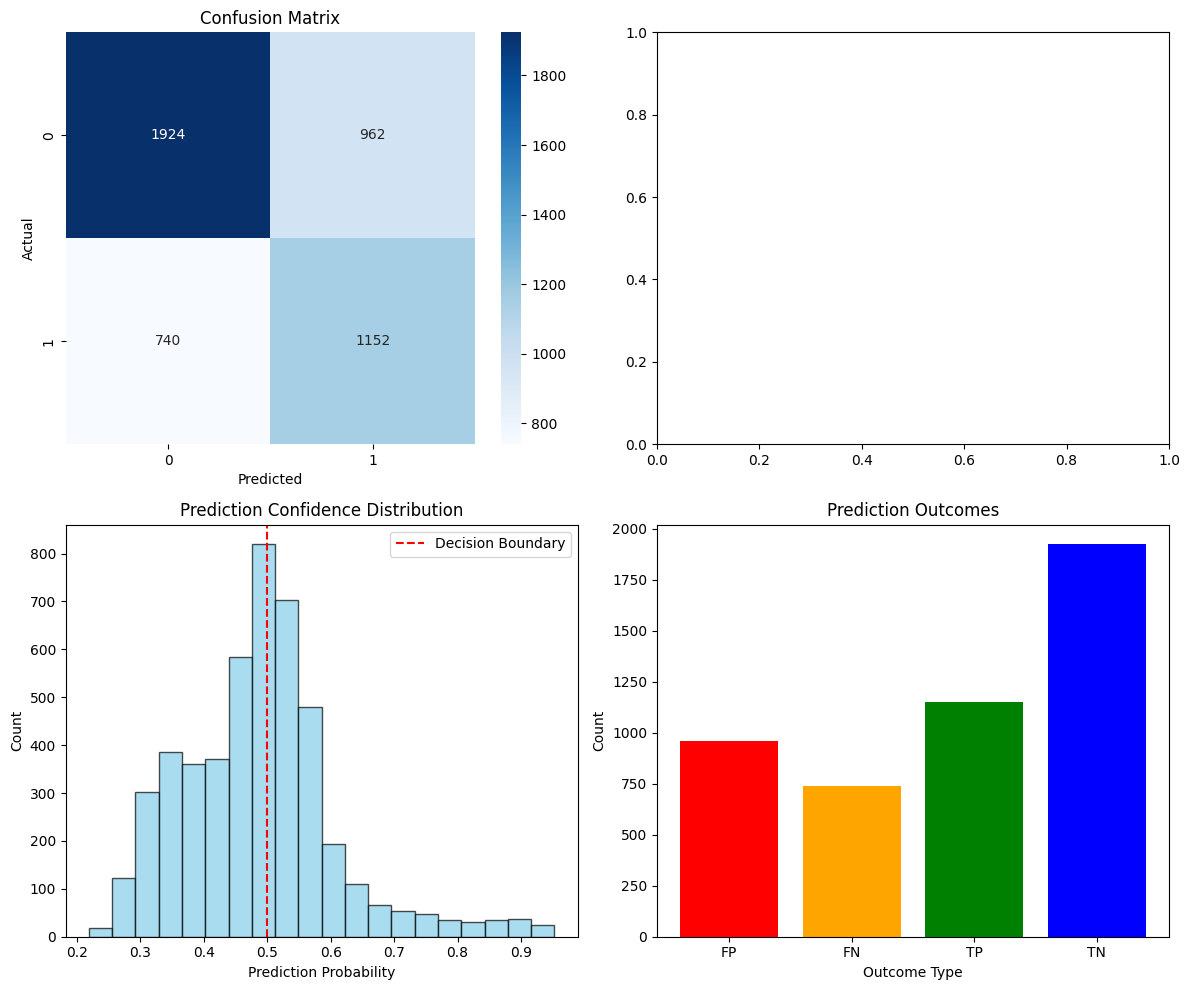

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def comprehensive_error_analysis(X_test, y_test, y_pred, y_pred_proba=None, 
                                 original_df=None, customer_id_col='numero_compte'):
    """
    Comprehensive error analysis after model retraining
    """
    print("=" * 80)
    print("COMPREHENSIVE ERROR ANALYSIS")
    print("=" * 80)
    
    results = {}
    
    # ========== 1. BASIC ERROR METRICS ==========
    print("\n📊 1. BASIC ERROR METRICS")
    print("-" * 60)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"Confusion Matrix:")
    print(f"  True Negatives:  {tn:>6} (Correctly rejected)")
    print(f"  False Positives: {fp:>6} (Predicted YES, actual NO) ← WASTED EFFORT")
    print(f"  False Negatives: {fn:>6} (Predicted NO, actual YES) ← MISSED OPPORTUNITIES")
    print(f"  True Positives:  {tp:>6} (Correctly predicted)")
    
    # Error rates
    total = len(y_test)
    fp_rate = fp / total * 100
    fn_rate = fn / total * 100
    error_rate = (fp + fn) / total * 100
    
    print(f"\nError Analysis:")
    print(f"  • Total errors: {fp + fn:,} ({error_rate:.1f}% of predictions)")
    print(f"  • False Positive rate: {fp_rate:.1f}% (wasted sales effort)")
    print(f"  • False Negative rate: {fn_rate:.1f}% (missed conversions)")
    
    results['confusion_matrix'] = cm
    results['error_rates'] = {'fp_rate': fp_rate, 'fn_rate': fn_rate, 'total_error': error_rate}
    
    # ========== 2. CONFIDENCE ANALYSIS ==========
    if y_pred_proba is not None:
        print(f"\n📈 2. PREDICTION CONFIDENCE ANALYSIS")
        print("-" * 60)
        
        # Create confidence bins
        confidence_bins = pd.cut(y_pred_proba, bins=[0, 0.3, 0.4, 0.6, 0.7, 1.0], 
                                labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        # Analyze accuracy by confidence level
        confidence_df = pd.DataFrame({
            'actual': y_test,
            'predicted': y_pred,
            'probability': y_pred_proba,
            'confidence_level': confidence_bins
        })
        
        accuracy_by_confidence = confidence_df.groupby('confidence_level').apply(
            lambda x: (x['actual'] == x['predicted']).mean() * 100
        )
        
        print("Accuracy by Confidence Level:")
        for level, accuracy in accuracy_by_confidence.items():
            count = (confidence_df['confidence_level'] == level).sum()
            print(f"  • {level:10} confidence: {accuracy:.1f}% accurate ({count:,} predictions)")
        
        # Identify low-confidence predictions (need human review)
        low_confidence_mask = (y_pred_proba >= 0.4) & (y_pred_proba <= 0.6)
        low_confidence_count = low_confidence_mask.sum()
        
        print(f"\n⚠️  Low Confidence Predictions (40-60%):")
        print(f"  • Count: {low_confidence_count:,} ({low_confidence_count/len(y_test)*100:.1f}% of predictions)")
        print(f"  • These need human review or better features")
        
        results['confidence_analysis'] = confidence_df
        results['low_confidence_count'] = low_confidence_count
    
    # ========== 3. FEATURE IMPORTANCE IN ERRORS ==========
    print(f"\n🔍 3. FEATURE ANALYSIS OF ERRORS")
    print("-" * 60)
    
    if isinstance(X_test, pd.DataFrame):
        # Combine predictions with features
        error_df = X_test.copy()
        error_df['actual'] = y_test.values if hasattr(y_test, 'values') else y_test
        error_df['predicted'] = y_pred
        error_df['is_error'] = (y_test != y_pred).astype(int)
        error_df['error_type'] = np.select(
            [
                (y_test == 0) & (y_pred == 1),  # False Positive
                (y_test == 1) & (y_pred == 0),  # False Negative
                (y_test == y_pred) & (y_test == 1),  # True Positive
                (y_test == y_pred) & (y_test == 0)   # True Negative
            ],
            ['FP', 'FN', 'TP', 'TN'],
            default='Unknown'
        )
        
        # Analyze feature distributions for each error type
        numeric_features = error_df.select_dtypes(include=[np.number]).columns.tolist()
        
        print("Feature Value Differences by Error Type (mean values):")
        
        # Select key features based on your analysis
        key_features = [
            'total_quotes', 'avg_days_between_quotes', 'engagement_density',
            'solution_complexity_score', 'equipment_variety_count',
            'brand_loyalty_index', 'process_customer_fit', 'consideration_depth_score'
        ]
        
        # Filter to features that exist
        available_features = [f for f in key_features if f in error_df.columns]
        
        if available_features:
            error_stats = error_df.groupby('error_type')[available_features].mean()
            print(error_stats.round(3).to_string())
            
            results['error_feature_stats'] = error_stats
            
            # Identify features with biggest differences
            print(f"\n📊 Key Feature Differences:")
            
            for feature in available_features[:5]:  # Top 5 features
                fp_mean = error_stats.loc['FP', feature] if 'FP' in error_stats.index else np.nan
                fn_mean = error_stats.loc['FN', feature] if 'FN' in error_stats.index else np.nan
                tp_mean = error_stats.loc['TP', feature] if 'TP' in error_stats.index else np.nan
                
                if not np.isnan(fp_mean) and not np.isnan(tp_mean):
                    fp_vs_tp_diff = fp_mean - tp_mean
                    print(f"  • {feature:30}: FP are {fp_vs_tp_diff:+.3f} vs TP")
                
                if not np.isnan(fn_mean) and not np.isnan(tp_mean):
                    fn_vs_tp_diff = fn_mean - tp_mean
                    print(f"  • {feature:30}: FN are {fn_vs_tp_diff:+.3f} vs TP")
    
    # ========== 4. SEGMENT-SPECIFIC ERROR ANALYSIS ==========
    print(f"\n🎯 4. ERROR ANALYSIS BY CUSTOMER SEGMENT")
    print("-" * 60)
    
    if original_df is not None and customer_id_col in original_df.columns:
        # Merge with original data for segment analysis
        if 'statut_client' in original_df.columns:
            segment_errors = pd.DataFrame({
                'customer_id': original_df[customer_id_col],
                'segment': original_df['statut_client'],
                'actual': y_test,
                'predicted': y_pred,
                'is_error': (y_test != y_pred).astype(int)
            })
            
            # Error rates by segment
            segment_error_rates = segment_errors.groupby('segment').agg(
                total_customers=('customer_id', 'count'),
                error_count=('is_error', 'sum'),
                fp_count=('is_error', lambda x: ((segment_errors.loc[x.index, 'actual'] == 0) & 
                                                (segment_errors.loc[x.index, 'predicted'] == 1)).sum()),
                fn_count=('is_error', lambda x: ((segment_errors.loc[x.index, 'actual'] == 1) & 
                                                (segment_errors.loc[x.index, 'predicted'] == 0)).sum())
            )
            
            segment_error_rates['error_rate'] = segment_error_rates['error_count'] / segment_error_rates['total_customers'] * 100
            segment_error_rates['fp_rate'] = segment_error_rates['fp_count'] / segment_error_rates['total_customers'] * 100
            segment_error_rates['fn_rate'] = segment_error_rates['fn_count'] / segment_error_rates['total_customers'] * 100
            
            print("Error Rates by Customer Segment:")
            print(segment_error_rates[['total_customers', 'error_rate', 'fp_rate', 'fn_rate']].round(1).to_string())
            
            results['segment_error_analysis'] = segment_error_rates
            
            # Identify worst-performing segment
            worst_segment = segment_error_rates['error_rate'].idxmax()
            worst_error_rate = segment_error_rates['error_rate'].max()
            
            print(f"\n⚠️  WORST PERFORMING SEGMENT:")
            print(f"  • {worst_segment}: {worst_error_rate:.1f}% error rate")
            print(f"  • Needs feature improvement or separate modeling")
    
    # ========== 5. PATTERN ANALYSIS OF FALSE NEGATIVES ==========
    print(f"\n💡 5. FALSE NEGATIVE ANALYSIS (MISSED OPPORTUNITIES)")
    print("-" * 60)
    
    if 'error_type' in locals() and 'FN' in error_df['error_type'].values:
        fn_df = error_df[error_df['error_type'] == 'FN']
        
        if len(fn_df) > 0:
            print(f"Analyzing {len(fn_df):,} missed opportunities:")
            
            # Common patterns in false negatives
            patterns = []
            
            # Pattern 1: High consideration but predicted low
            if 'consideration_depth_score' in fn_df.columns:
                high_consideration_fn = (fn_df['consideration_depth_score'] > 0.6).sum()
                patterns.append(f"• {high_consideration_fn:,} had high consideration depth (>0.6)")
            
            # Pattern 2: Wrong process used
            if 'process_customer_fit' in fn_df.columns:
                poor_process_fit_fn = (fn_df['process_customer_fit'] < 0.4).sum()
                patterns.append(f"• {poor_process_fit_fn:,} had poor process fit (<0.4)")
            
            # Pattern 3: Multi-quote customers
            if 'total_quotes' in fn_df.columns:
                multi_quote_fn = (fn_df['total_quotes'] > 1).sum()
                patterns.append(f"• {multi_quote_fn:,} were multi-quote customers")
            
            # Pattern 4: Specific equipment types
            if 'regroup_famille_equipement_produit' in fn_df.columns:
                top_equipment_fn = fn_df['regroup_famille_equipement_produit'].value_counts().head(3)
                patterns.append(f"• Top equipment in FNs: {', '.join(top_equipment_fn.index.tolist())}")
            
            for pattern in patterns:
                print(f"  {pattern}")
            
            results['fn_patterns'] = patterns
    
    # ========== 6. RECOMMENDATIONS ==========
    print(f"\n🎯 6. ACTIONABLE RECOMMENDATIONS")
    print("=" * 60)
    
    recommendations = []
    
    # Based on error analysis
    if fp_rate > fn_rate:
        recommendations.append("Model is TOO AGGRESSIVE (too many False Positives)")
        recommendations.append("→ Increase prediction threshold")
        recommendations.append("→ Add features to identify 'tire-kickers'")
    else:
        recommendations.append("Model is TOO CONSERVATIVE (too many False Negatives)")
        recommendations.append("→ Decrease prediction threshold")
        recommendations.append("→ Improve features for high-potential customers")
    
    if 'low_confidence_count' in results and results['low_confidence_count'] > 0.1 * len(y_test):
        recommendations.append(f"Too many uncertain predictions ({results['low_confidence_count']/len(y_test)*100:.1f}%)")
        recommendations.append("→ Need better features for edge cases")
        recommendations.append("→ Consider human review for 40-60% confidence range")
    
    if 'worst_segment' in locals():
        recommendations.append(f"Segment '{worst_segment}' has highest error rate")
        recommendations.append(f"→ Create segment-specific features")
        recommendations.append(f"→ Consider separate model for this segment")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i:2d}. {rec}")
    
    return results

# ========== ADDITIONAL ANALYSIS TOOLS ==========

def analyze_feature_contribution_to_errors(model, X_test, y_test, y_pred):
    """
    Analyze which features contribute most to errors
    """
    print("\n🔬 FEATURE CONTRIBUTION TO ERRORS")
    print("-" * 60)
    
    # Get feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))
    
    # Analyze SHAP values if available
    try:
        import shap
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # Analyze SHAP for errors
        error_mask = (y_test != y_pred)
        if error_mask.any():
            print("\nSHAP Analysis for Errors:")
            error_shap = shap_values[error_mask]
            error_features = X_test.columns[np.abs(error_shap).mean(axis=0).argsort()[-5:][::-1]]
            
            print("Features with largest SHAP impact on errors:")
            for feat in error_features:
                print(f"  • {feat}")
    
    except ImportError:
        print("SHAP not available for detailed error analysis")
    except:
        print("Could not compute SHAP values")

def create_error_visualization(results, y_test, y_pred, y_pred_proba=None):
    """
    Create visualizations of error patterns
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Confusion matrix heatmap
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. Error rates by segment (if available)
    if 'segment_error_analysis' in results:
        segment_data = results['segment_error_analysis']
        segment_data['error_rate'].plot(kind='bar', ax=axes[0, 1], color='coral')
        axes[0, 1].set_title('Error Rate by Customer Segment')
        axes[0, 1].set_xlabel('Segment')
        axes[0, 1].set_ylabel('Error Rate (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Prediction confidence distribution
    if y_pred_proba is not None:
        axes[1, 0].hist(y_pred_proba, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 0].axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
        axes[1, 0].set_title('Prediction Confidence Distribution')
        axes[1, 0].set_xlabel('Prediction Probability')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].legend()
    
    # 4. Error type comparison
    error_types = ['FP', 'FN', 'TP', 'TN']
    error_counts = [
        ((y_test == 0) & (y_pred == 1)).sum(),
        ((y_test == 1) & (y_pred == 0)).sum(),
        ((y_test == 1) & (y_pred == 1)).sum(),
        ((y_test == 0) & (y_pred == 0)).sum()
    ]
    
    colors = ['red', 'orange', 'green', 'blue']
    axes[1, 1].bar(error_types, error_counts, color=colors)
    axes[1, 1].set_title('Prediction Outcomes')
    axes[1, 1].set_xlabel('Outcome Type')
    axes[1, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()



# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    X_test = __result['X_test']
    y_test = __result['y_test']
    model = __result['model']
    y_pred = model.predict(X_test)

    
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    comprehensive_error_analysis(X_test, y_test, y_pred, y_pred_proba)

    # 3. Run comprehensive error analysis
    error_results = comprehensive_error_analysis(
        X_test=X_test,
        y_test=y_test,
        y_pred=y_pred,
        y_pred_proba=y_pred_proba,
        original_df=X_new_clean,  # For segment analysis
        customer_id_col='numero_compte'
    )
    
    # 4. Additional analysis
    analyze_feature_contribution_to_errors(model, X_test, y_test, y_pred)
    
    # 5. Visualize errors
    create_error_visualization(error_results, y_test, y_pred, y_pred_proba)

